In [1]:
import sys
sys.path.append('../')

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100

%matplotlib inline

radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]

unique_roles = [
    'Carry',
    'Disabler',
    'Durable',
    'Escape',
    'Initiator',
    'Jungler',
    'Nuker',
    'Pusher',
    'Support'
]

unique_primary_attrs = [
    'agi',
    'int',
    'str'
]

In [2]:
df = pd.read_csv('../data/matches_data.csv')
df.head()

,match_id,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,radiant_win
0,4154000815,83,64,93,99,22,110,32,41,92,11,False
1,4152494309,23,120,82,18,26,108,31,7,14,44,False
2,4152425012,121,18,106,21,86,10,82,112,110,14,False
3,4152417604,77,93,45,26,7,119,14,4,106,70,False
4,4152114308,9,114,37,56,96,74,6,2,112,121,False


In [3]:
cols_to_drop = [str(i) + '_pick' for i in range(1, 9)] + [str(i) + '_win' for i in range(1, 9)]
cols_to_drop += [
    'cm_enabled',  # uninformative
    'hero_id',  # uninformative
    'icon',  # uninformative
    'img',  # uninformative
    'localized_name',  # uninformative
    'name',  # uninformative
    'base_mana',  # nunique = 1
    'base_mana_regen',  # nunique = 1
    'base_health',  # nunique = 1
]

In [4]:
with open('../data/hero_stats.json', 'r') as f:
    heroes_stats = json.load(f)
    heroes_stats = pd.DataFrame(heroes_stats).set_index('id')
no_heroes = len(heroes_stats)
heroes_stats = heroes_stats.drop(cols_to_drop, axis=1)
heroes_stats = heroes_stats.fillna(0)
heroes_stats.head()

,agi_gain,attack_range,attack_rate,attack_type,base_agi,base_armor,base_attack_max,base_attack_min,base_health_regen,base_int,base_mr,base_str,int_gain,legs,move_speed,primary_attr,pro_ban,pro_pick,pro_win,projectile_speed,roles,str_gain,turn_rate
id,,,,,,,,,,,,,,,,,,,,,,,
1,2.8,150,1.4,Melee,22,-1.0,33,29,1.75,12,25,23,1.8,2,310,agi,20.0,17.0,10.0,0,"[Carry, Escape, Nuker]",1.3,0.5
2,2.2,150,1.7,Melee,20,-2.0,28,24,4.25,18,25,25,1.6,2,290,str,43.0,57.0,33.0,900,"[Initiator, Durable, Disabler, Jungler]",2.8,0.6
3,2.4,400,1.7,Ranged,23,1.0,41,35,1.50,23,25,23,2.4,4,310,int,48.0,87.0,44.0,900,"[Support, Disabler, Nuker, Durable]",2.4,0.6
4,3.0,150,1.7,Melee,24,0.0,39,33,1.50,18,25,24,1.7,2,285,agi,89.0,53.0,26.0,900,"[Carry, Disabler, Jungler, Nuker, Initiator]",2.7,0.5
5,1.6,600,1.7,Ranged,16,0.0,32,26,1.50,14,25,18,2.9,2,275,int,5.0,67.0,41.0,900,"[Support, Disabler, Nuker, Jungler]",2.0,0.5


In [5]:
heroes_stats.drop('roles', axis=1).nunique()

agi_gain             33
attack_range         25
attack_rate           9
attack_type           2
base_agi             20
base_armor           11
base_attack_max      35
base_attack_min      33
base_health_regen     8
base_int             17
base_mr               2
base_str             17
int_gain             33
legs                  5
move_speed           14
primary_attr          3
pro_ban              67
pro_pick             70
pro_win              55
projectile_speed     13
str_gain             25
turn_rate             7
dtype: int64

In [6]:
cont_variables = [
    'agi_gain',
    'attack_range',
    'attack_rate',
    'base_agi',
    'base_armor',
    'base_attack_max',
    'base_attack_min',
    'base_health_regen',
    'base_int',
    'base_mr',
    'base_str',
    'int_gain',
    'legs',
    'move_speed',
    'pro_ban',
    'pro_pick',
    'pro_win',
    'projectile_speed',
    'str_gain',
    'turn_rate',
]

cat_variables = [
    'attack_type',
    'primary_attr',
    'roles',
]

In [7]:
def features(row, is_radiant=True):

    features = {'match_id': row['match_id']}
    features.update({col: 0 for col in cont_variables})
    features.update({
        'no_agi': 0,
        'no_int': 0,
        'no_str': 0,
        'no_melees': 0,
        'no_Carry': 0,
        'no_Disabler': 0,
        'no_Durable': 0,
        'no_Escape': 0,
        'no_Initiator': 0,
        'no_Jungler': 0,
        'no_Nuker': 0,
        'no_Pusher': 0,
        'no_Support': 0,
    })
    
    hero_cols = radiant_cols if is_radiant else dire_cols
    
    values = {col: [] for col in cont_variables}
    
    for i, hero in row[hero_cols].iteritems():
        
        hero_row = heroes_stats.loc[hero]
        
        for col in cont_variables:
            features[col] += hero_row[col]
            values[col].append(hero_row[col])
            
        if hero_row['attack_type'] == 'Melee':
            features['no_melees'] += 1
            
        for attr in unique_primary_attrs:
            if hero_row['primary_attr'] == attr:
                features['no_{}'.format(attr)] += 1
            
        for role in unique_roles:
            if role in hero_row['roles']:
                features['no_{}'.format(role)] += 1
                
    filter_cols = ['base_mr']
    features.update({'min_' + col: min(l) for col, l in values.items() if col not in filter_cols})
    features.update({'max_' + col: max(l) for col, l in values.items() if col not in filter_cols})
    
    return pd.Series(features)

In [8]:
radiant_features = df.apply(lambda x: features(x), axis=1)
dire_features = df.apply(lambda x: features(x, is_radiant=False), axis=1)

In [9]:
radiant_features.head()

,match_id,agi_gain,attack_range,attack_rate,base_agi,base_armor,base_attack_max,base_attack_min,base_health_regen,base_int,base_mr,base_str,int_gain,legs,move_speed,pro_ban,pro_pick,pro_win,projectile_speed,str_gain,turn_rate,no_agi,no_int,no_str,no_melees,no_Carry,no_Disabler,no_Durable,no_Escape,no_Initiator,no_Jungler,no_Nuker,no_Pusher,no_Support,min_agi_gain,min_attack_range,min_attack_rate,min_base_agi,min_base_armor,min_base_attack_max,min_base_attack_min,min_base_health_regen,min_base_int,min_base_str,min_int_gain,min_legs,min_move_speed,min_pro_ban,min_pro_pick,min_pro_win,min_projectile_speed,min_str_gain,min_turn_rate,max_agi_gain,max_attack_range,max_attack_rate,max_base_agi,max_base_armor,max_base_attack_max,max_base_attack_min,max_base_health_regen,max_base_int,max_base_str,max_int_gain,max_legs,max_move_speed,max_pro_ban,max_pro_pick,max_pro_win,max_projectile_speed,max_str_gain,max_turn_rate
0,4.154001e+09,7.7,1230.0,8.8,74.0,-2.0,219.0,177.0,9.25,96.0,125.0,116.0,11.80,10.0,1435.0,295.0,211.0,108.0,4000.0,12.40,3.20,1.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,0.0,4.0,1.0,2.0,1.2,150.0,1.7,10.0,-2.0,32.0,22.0,1.5,14.0,21.0,1.7,2.0,265.0,2.0,7.0,4.0,0.0,1.9,0.5,2.0,400.0,1.9,21.0,1.0,70.0,62.0,3.25,26.0,27.0,2.8,2.0,300.0,184.0,95.0,48.0,1100.0,3.6,1.0
1,4.152494e+09,9.8,1200.0,8.6,91.0,5.0,177.0,147.0,8.00,88.0,125.0,106.0,9.30,10.0,1485.0,148.0,103.0,56.0,3600.0,12.40,3.35,2.0,1.0,2.0,4.0,4.0,5.0,3.0,2.0,5.0,0.0,5.0,1.0,2.0,1.3,150.0,1.7,14.0,-1.0,26.0,20.0,1.5,16.0,17.0,1.3,2.0,285.0,3.0,3.0,1.0,0.0,1.6,0.5,2.8,600.0,1.8,23.0,3.0,45.0,43.0,1.75,20.0,24.0,3.0,2.0,310.0,91.0,59.0,32.0,900.0,3.3,1.0
2,4.152425e+09,8.7,2000.0,8.4,92.0,-2.0,175.0,143.0,8.00,102.0,125.0,102.0,11.40,10.0,1470.0,71.0,174.0,82.0,4175.0,12.20,3.20,1.0,3.0,1.0,2.0,3.0,5.0,1.0,3.0,2.0,0.0,5.0,0.0,3.0,1.4,150.0,1.5,14.0,-1.0,29.0,19.0,1.5,16.0,17.0,1.3,2.0,285.0,0.0,0.0,0.0,0.0,1.8,0.5,2.0,600.0,1.8,22.0,1.0,45.0,43.0,2.00,25.0,23.0,3.3,2.0,305.0,40.0,68.0,39.0,1250.0,3.0,0.8
3,4.152418e+09,6.4,1680.0,8.5,80.0,-3.0,175.0,138.0,10.25,91.0,125.0,105.0,12.40,10.0,1530.0,347.0,374.0,195.0,2700.0,12.20,3.00,1.0,2.0,2.0,3.0,2.0,3.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,150.0,1.7,12.0,-2.0,27.0,19.0,1.5,16.0,18.0,1.4,2.0,290.0,6.0,7.0,4.0,0.0,1.8,0.5,1.5,630.0,1.7,21.0,1.0,41.0,33.0,3.25,24.0,25.0,4.5,2.0,335.0,149.0,206.0,109.0,900.0,3.3,0.9
4,4.152114e+09,11.0,2320.0,8.5,87.0,-4.0,158.0,129.0,9.25,92.0,125.0,100.0,9.45,12.0,1480.0,223.0,331.0,169.0,4800.0,13.95,2.60,3.0,1.0,1.0,2.0,3.0,4.0,1.0,4.0,3.0,0.0,2.0,1.0,2.0,1.0,150.0,1.7,10.0,-3.0,21.0,15.0,1.5,15.0,12.0,1.6,2.0,295.0,6.0,6.0,3.0,900.0,1.9,0.5,3.2,640.0,1.7,22.0,1.0,38.0,36.0,3.00,22.0,27.0,2.7,4.0,300.0,73.0,164.0,89.0,1200.0,4.3,0.6


In [10]:
radiant_features.isnull().sum()

match_id                 0
agi_gain                 0
attack_range             0
attack_rate              0
base_agi                 0
base_armor               0
base_attack_max          0
base_attack_min          0
base_health_regen        0
base_int                 0
base_mr                  0
base_str                 0
int_gain                 0
legs                     0
move_speed               0
pro_ban                  0
pro_pick                 0
pro_win                  0
projectile_speed         0
str_gain                 0
turn_rate                0
no_agi                   0
no_int                   0
no_str                   0
no_melees                0
no_Carry                 0
no_Disabler              0
no_Durable               0
no_Escape                0
no_Initiator             0
                        ..
min_base_int             0
min_base_str             0
min_int_gain             0
min_legs                 0
min_move_speed           0
min_pro_ban              0
m

In [11]:
assert (radiant_features.nunique() != 1).all()
assert (dire_features.nunique() != 1).all()

In [12]:
assert (radiant_features.isnull().sum() == 0).all()
assert (dire_features.isnull().sum() == 0).all()

In [13]:
radiant_features.to_csv('../data/radiant_features.csv', index=False)
dire_features.to_csv('../data/dire_features.csv', index=False)

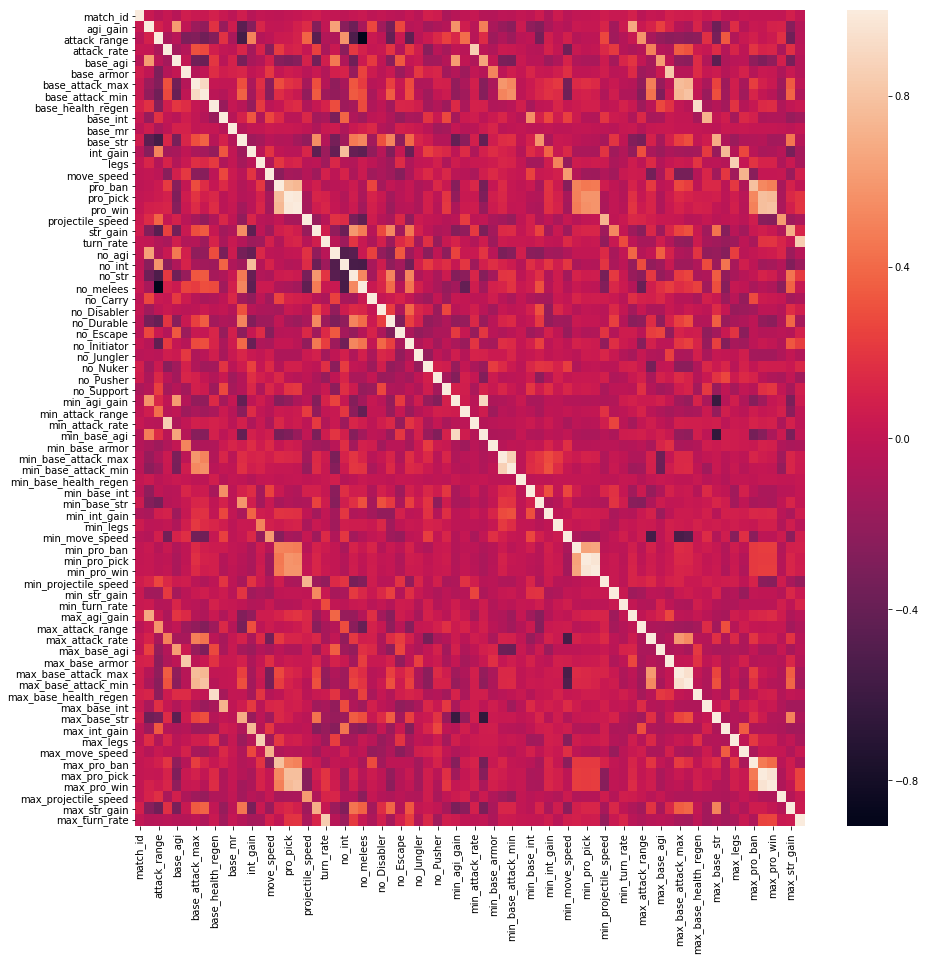

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(radiant_features.corr())